# Generate sample from 3D GZ with Euler-Maruyama

Saved data at iteration 0, total violation is 0
Saved data at iteration 1, total violation is 0
Saved data at iteration 2, total violation is 0
Saved data at iteration 3, total violation is 0
Saved data at iteration 4, total violation is 0
Saved data at iteration 5, total violation is 0
Saved data at iteration 6, total violation is 0
Saved data at iteration 7, total violation is 0
Saved data at iteration 8, total violation is 0
Saved data at iteration 9, total violation is 0
Saved data at iteration 10, total violation is 0
Saved data at iteration 11, total violation is 0
Saved data at iteration 12, total violation is 0
Saved data at iteration 13, total violation is 0
Saved data at iteration 14, total violation is 0
Saved data at iteration 15, total violation is 0
Saved data at iteration 16, total violation is 0
Saved data at iteration 17, total violation is 0
Saved data at iteration 18, total violation is 0
Saved data at iteration 19, total violation is 0
Saved data at iteration 20, to

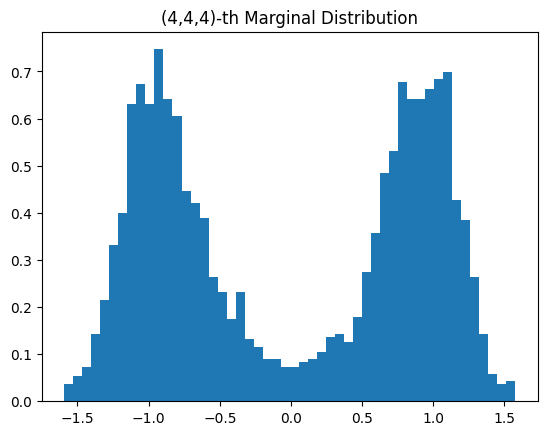

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Given constants
n = 4
d = n**3
h = 1 / (n + 1)
λ = 0.01
β = 6.4

scale = 200
dt = 0.0005 * scale
N = int(1*scale/dt)  # Interested in T = 1
dt = 1*scale/N  # Correct for small deviation

BATCH_SIZE = 100  # Set your desired batch size

data_path = f"./Saved_Data/3D_GZ_data_d_{d}.npz"

# Hyperparameters
hyperparameters = {
    "d": d,
    "h": h,
    "λ": λ,
    "β": β,
    "dt": dt,
    "N": N,
    "BATCH_SIZE": BATCH_SIZE
}

# # Create directory if it doesn't exist
# if not os.path.exists("./Saved_Data"):
#     os.makedirs("./Saved_Data")

# # Load existing data or initialize
# if os.path.exists(data_path):
#     with np.load(data_path) as data:
#         all_samples = data['samples']
# else:
#     all_samples = np.empty((0, n + 2, n + 2, n + 2))

if os.path.exists(data_path):
    os.remove(data_path)

all_samples = np.empty((0, n + 2, n + 2, n + 2))

def V_grad(U):
    """
    Compute the gradient of the potential energy V for a periodic domain.
    
    Args:
    - U (np.ndarray): Input tensor for which the gradient is computed.
    
    Returns:
    - np.ndarray: Gradient of the potential energy V.
    """
    return ( λ/h**2 * (
        6*U - np.roll(U, 1, axis=1) - np.roll(U, -1, axis=1) 
        - np.roll(U, -1, axis=2) - np.roll(U, 1, axis=2)
        - np.roll(U, -1, axis=3) - np.roll(U, 1, axis=3)
    ) - U * (1 - U**2) /λ ) / d

count = 0


for iteration in range(30):

    U = np.zeros((BATCH_SIZE, n + 2, n + 2, n + 2))  # Initialize at each iteration

    # Creating samples for 1D Ginzburg Landau
    for _ in range(N):
        dW = np.sqrt(dt) * np.random.randn(BATCH_SIZE, n + 2, n + 2, n + 2)
        U[:, 1:-1, 1:-1, 1:-1] += (-V_grad(U)[:, 1:-1, 1:-1, 1:-1] * dt + np.sqrt(2/β) * dW[:, 1:-1, 1:-1, 1:-1])
        count += np.sum(U > 2.5) + np.sum(U <-2.5)
        U[U > 2.5] = 2.5
        U[U < -2.5] = -2.5
    all_samples = np.concatenate((all_samples, U), axis=0)
    print(f'Saved data at iteration {iteration}, total violation is {count}')

    # Save the accumulated data
    np.savez(data_path, samples=all_samples, hyperparameters=hyperparameters)

# Visualization of the 8-th marginal distribution
eighth_samples = all_samples[:, 4, 4, 4]  # Extract the 4-th bit from each sample
plt.hist(eighth_samples, bins=50, density=True)
plt.title("(4,4,4)-th Marginal Distribution")
plt.show()
